## - 유관 상피세포의 암세포가 기저막을 뚫고 통과하여 결합조직에 침범이 있는 경우를 "침윤성 유관암(IDC; Invasive Ductal Carcinoma)이라 함"


## - 이미지에서 IDC를 Detection 하도록 학습시켜 유방암 진단모델 생성

### 1. PREPARING DATA & PREPROCESSING
50x50, png 형식의 유방 조직세포 이미지  277,524장 (198,738 IDC 음성 and 78,786 IDC 양성). 

In [166]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocessing

In [167]:
# 이미지 데이터 폴더 탐색 및 폴더목록 리스트화(이후활용)
# 폴더목록명은 각 환자의 ID
os.listdir('IDC_regular_ps50_idx5')[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262',
 '10264',
 '10268',
 '10269',
 '10272',
 '10273',
 '10274',
 '10275',
 '10276',
 '10277',
 '10278',
 '10279',
 '10282',
 '10285',
 '10286',
 '10288',
 '10290',
 '10291',
 '10292',
 '10293',
 '10295',
 '10299',
 '10300',
 '10301',
 '10302',
 '10303',
 '10304',
 '10305',
 '10306',
 '10307',
 '10308',
 '12241',
 '12242',
 '12626',
 '12748',
 '12749',
 '12750',
 '12751',
 '12752',
 '12810',
 '12811',
 '12817',
 '12818',
 '12819',
 '12820',
 '12821',
 '12822',
 '12823',
 '12824',
 '12826',
 '12867',
 '12868',
 '12869',
 '12870',
 '12871',
 '12872',
 '12873',
 '12875',
 '12876',
 '12877',
 '12878',
 '12879',
 '12880',
 '12881',
 '12882',
 '12883',
 '12884',
 '12886',
 '12890',
 '12891',
 '12892',
 '12893',
 '12894',
 '12895',
 '12896',
 '12897',
 '12898',
 '12900',
 '12901',
 '12905',
 '12906',
 '12907',
 '12908',
 '12909',
 '12910',
 '12911',
 '12929',
 '12930',
 '12931',
 '12932',
 '12933',


In [168]:
patients = os.listdir('IDC_regular_ps50_idx5')
len(patients) #폴더 개수 확인

279

In [169]:
# 각각 다른폴더에 저장된 이미지들을 한곳에 통합하기 위한 폴더 생성
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

In [170]:
# all_images_dir 폴더 생성 확인
!ls

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [171]:
# 실행하는데 시간 많이 소요(이미지 파일 전체 복사과정이기 때문에)

# all_images_dir라는 폴더로 모든 이미지 복사

# 폴더명(환자ID)의 리스트를 만들어서 각 하위에 있는 0과 1폴더의 사진들을 분류.
# 0과 1은 IDC(종양)의 negative와 positive를 뜻함

patient_list = os.listdir('IDC_regular_ps50_idx5')

for patient in patient_list:
    
    path_0 = 'IDC_regular_ps50_idx5/' + str(patient) + '/0' # 모든 각 환자 폴더의 하위폴더 0에 있는 이미지를 path_0에 모두 저장한다.
    path_1 = 'IDC_regular_ps50_idx5/' + str(patient) + '/1' # 모든 각 환자 폴더의 하위폴더 1에 있는 이미지를 path_1에 모두 저장한다.


    # file_list_0이라는 폴더를 만들어 0에 해당하는 이미지 모두 저장
    file_list_0 = os.listdir(path_0)
    # file_list_1이라는 폴더를 만들어 1에 해당하는 이미지 모두 저장
    file_list_1 = os.listdir(path_1)

    # 결과 0에 해당하는 이미지를 all_images_dir폴더에 저장
    for fname in file_list_0:

        # src라는 파일이름으로 원본파일이름을 저장
        src = os.path.join(path_0, fname)
        # dst라는 파일이름으로 새로 저장할 이름 저장
        dst = os.path.join(all_images_dir, fname)
        # src에서 dst라는 이름으로 파일을 복사.
        shutil.copyfile(src, dst)


    for fname in file_list_1:

        src = os.path.join(path_1, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)

In [172]:
# all_images_dir 폴더에 모든 이미지 복사여부 확인
len(os.listdir('all_images_dir'))

277524

### 이미지 이름에서 PATIENT ID와 TARGET 값 추출

In [173]:
# 이미지 id 정보를 담은 df생성
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])
df_data.head()

,image_id
0,10253_idx5_x1001_y1001_class0.png
1,10253_idx5_x1001_y1051_class0.png
2,10253_idx5_x1001_y1101_class0.png
3,10253_idx5_x1001_y1151_class0.png
4,10253_idx5_x1001_y1201_class0.png


In [174]:
# 이미지 id를 내용별로 나누고 새로운 컬럼에 값 삽입

# string형식인 image id에서 인덱싱, 추출을 이용하여 정보 분리하는 함수생성

# image id 예시: '14211_idx5_x2401_y1301_class1.png' 
# -> 14211(환자ID), class1(인덱싱자리5에 있는 숫자 1이 종속변수)

def extract_patient_id(x):
    a = x.split('_')
    patient_id = a[0]    
    return patient_id

def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    
    return target


# 'patient_id'컬럼생성, 생성한 함수를 이용한 값 생성
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# 'target'컬럼생성, 생성한 함수를 이용한 값 생성
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

,image_id,patient_id,target
0,10253_idx5_x1001_y1001_class0.png,10253,0
1,10253_idx5_x1001_y1051_class0.png,10253,0
2,10253_idx5_x1001_y1101_class0.png,10253,0
3,10253_idx5_x1001_y1151_class0.png,10253,0
4,10253_idx5_x1001_y1201_class0.png,10253,0
5,10253_idx5_x1001_y1251_class0.png,10253,0
6,10253_idx5_x1001_y1301_class0.png,10253,0
7,10253_idx5_x1001_y1351_class0.png,10253,0
8,10253_idx5_x1001_y1501_class0.png,10253,0
9,10253_idx5_x1001_y1551_class0.png,10253,0


In [175]:
# df구조확인
df_data.shape

(277524, 3)

In [176]:
# # 이미지 확인
# IMAGE_PATH = 'all_images_dir/'

# draw_category_images('target',4, df_data, IMAGE_PATH)

In [177]:
# target 0과 1인 파일 개수 비율 확인
df_data['target'].value_counts()

# 비율조정필요(양성의 수가 너무 적기 때문에 학습에 어려움, 성능에 영향)

0    198738
1     78786
Name: target, dtype: int64

In [178]:
# 비율조정필요 (양성의 수가 너무 적기 때문에 학습에 어려움, 성능에 영향)
SAMPLE_SIZE = 78786 # target 1인 파일의 수
IMAGE_SIZE = 50

# target 0인 파일에서 샘플개수만큼 추출 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# target 0인 파일에서 샘플개수만큼 추출 (total = 78786)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# df_0과 df_1 병합
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# target 0과 1의 비율 조정 완료
df_data['target'].value_counts()

1    78786
0    78786
Name: target, dtype: int64

### SPLITING TRAIN/TEST DATA

In [179]:
# stratify=y -> test셋에 0과 1의 비율을 맞추어줌
y = df_data['target']

df_train, df_test = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_test.shape)

(141814, 3)
(15758, 3)


In [180]:
print('<TrainSet target value counts>')
print(df_train['target'].value_counts())
print('-'*20)
print('<TestSet target value counts>')
print(df_test['target'].value_counts())

<TrainSet target value counts>
1    70907
0    70907
Name: target, dtype: int64
--------------------
<TestSet target value counts>
1    7879
0    7879
Name: target, dtype: int64


In [181]:
# 처음 열 때 이후에 실행 X !!

# 분류한 훈련셋과 검증셋 이미지데이터를 이동하기 위해 폴더 또한 동일하게 생성 및 나누고 이미지를 저장하는 과정


# 새로운 폴더 생성
base_dir = 'base_dir'
os.mkdir(base_dir)


# base_dir폴더 내에 아래 구조대로 생성

# train_dir
    # a_no_idc
    # b_has_idc

# test_dir
    # a_no_idc
    # b_has_idc



# base_dir 아래 새 폴더 생성
# train_dir
train_dir = os.path.join(base_dir, 'train_dir') # 경로 생성
os.mkdir(train_dir) # 생성경로대로 새 디렉토리(폴더) 생성

# test_dir
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND testIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# train_dir 아래 target 0과 1에 해당하는 폴더 생성
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)


# test_dir 아래 target 0과 1에 해당하는 폴더 생성
a_no_idc = os.path.join(test_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(test_dir, 'b_has_idc')
os.mkdir(b_has_idc)

In [182]:
# 폴더 생성 확인
os.listdir('base_dir/train_dir')

['a_no_idc', 'b_has_idc']

In [183]:
# df_data의 인덱스를 image_id로 설정
df_data.set_index('image_id', inplace=True)

In [184]:
df_data.head()

,patient_id,target
image_id,,
10288_idx5_x1251_y301_class0.png,10288,0
10301_idx5_x201_y1501_class0.png,10301,0
16550_idx5_x3551_y1251_class0.png,16550,0
10305_idx5_x2251_y651_class0.png,10305,0
12819_idx5_x2351_y1951_class0.png,12819,0


In [185]:
# train과 test 이미지 목록을 리스트로 가져온다.
train_list = list(df_train['image_id'])
test_list = list(df_test['image_id'])



# 폴더 생성 및 Train 이미지 복사 이동

for image in train_list:
    
    # image에 image_id들이 담겨있다.
    fname = image
    # image_id별 target컬럼만 추출
    target = df_data.loc[image,'target']
    
    # target대로 이미지 폴더에 분류
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    #원본통합 폴더(all_images_dir)에서 train set에 해당하는 이미지를 복사, 이동.
    src = os.path.join(all_images_dir, fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.move(src, dst)
    

# 폴더 생성 및 Test 이미지 복사 이동

for image in test_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    


    src = os.path.join(all_images_dir, fname)
    dst = os.path.join(test_dir, label, fname)
    shutil.move(src, dst)

In [186]:
# 폴더별 이미지개수 확인
print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))
print('-'*20)
print(len(os.listdir('base_dir/test_dir/a_no_idc')))
print(len(os.listdir('base_dir/test_dir/b_has_idc')))

70907
70907
--------------------
7879
7879


### 2. MODELING

In [187]:
train_path = 'base_dir/train_dir'
test_path = 'base_dir/test_dir'


num_train_samples = len(df_train)
num_test_samples = len(df_test)
train_batch_size = 10
test_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

datagen = ImageDataGenerator(rescale=1.0/255)

In [188]:
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=test_batch_size,
                                        class_mode='categorical')

# # 테스트셋 섞지 않음(shuffle=False)
# test_gen = datagen.flow_from_directory(testid_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=1,
#                                         class_mode='categorical',
#                                         shuffle=False)

Found 141814 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


In [189]:
def Model_Compiling_CNN():
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.3

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    model.summary()
    
model = Model_Compiling_CNN()
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 18, 64)        36928     
__________

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='test_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='test_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=test_gen,
                    validation_steps=test_steps,
                    epochs=2, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/8
 3115/14182 [=====>........................] - ETA: 35:47 - loss: 0.5226 - acc: 0.7491 ETA: 36:20 - loss - ETA: 36:11 - loss: 0.5237 - acc:  - ETA: 36:04 - loss: 0.52 - ETA: 35:56  - ETA: 35:53 - loss - ETA: 35:50 - loss: 0.5225 - acc: 0.74 - ETA: 35:5

In [136]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'acc']

In [ ]:
# Here the best epoch will be used.
model.load_weights('model.h5')

test_loss, test_acc = \
model.etestuate_generator(test_gen, 
                        steps=len(df_test))

print('test_loss:', test_loss)
print('test_acc:', test_acc)

In [137]:
# 무작위 추출을 통한 검증
predictions = model.predict_generator(test_gen, steps = len(df_test), verbose = 1)
predictions.shape

1576/1576 [==============================] - 87s 55ms/step


(15758, 2)

In [138]:
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [139]:
# 검증결과 데이터프레임화
# The columns need to be oredered to match the output of the previous cell
df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])
df_preds.head()

,no_idc,has_idc
0,0.101954,0.898046
1,0.094674,0.905326
2,0.320054,0.679946
3,0.070316,0.929684
4,0.941804,0.058196


In [ ]:
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)
# auc점수 확인 - 의료에서 중요 (FN이 적은 것이 중요하기 때문)

In [141]:
test_labels = test_gen.classes

# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [142]:
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [150]:
cm

array([[3498, 4381],
       [3434, 4445]], dtype=int64)

In [151]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

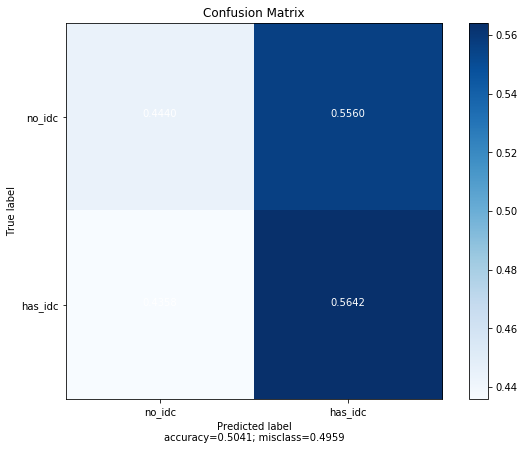

In [152]:
cm_plot_labels = ['no_idc', 'has_idc']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Accuracy(정확도)보다도 Recall(재현율) 과 F1 Score 중요.
# Recall=TP/TP + FN, 즉 FN이 작아야하는 것이 의료에서 매우 중요, 

from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)